# Unsupervised Learning Techniques

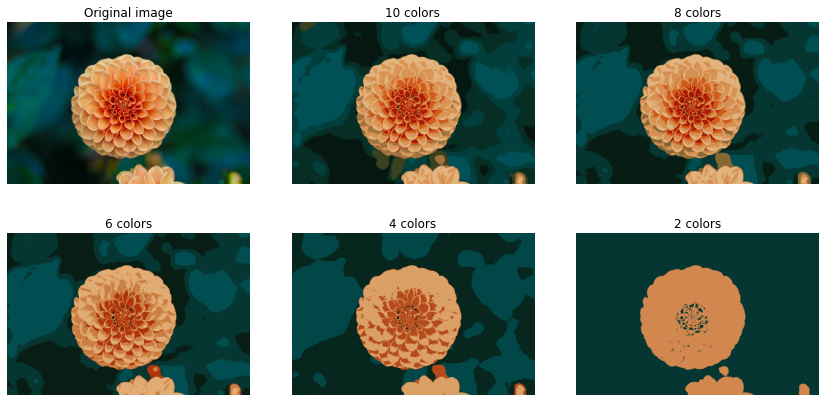

In [1]:
"""
Clustering for color segmentation
"""

from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

N = [10, 8, 6, 4, 2]

image = load_sample_image('flower.jpg')
X = image.reshape(-1, 3)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
fig.tight_layout()

[axi.set_axis_off() for axi in ax.ravel()]

ax[0, 0].imshow(image)
ax[0, 0].set_title("Original image")

for i, p in enumerate([(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]):
    kmeans = KMeans(n_clusters=N[i]).fit(X)
    seg_img = kmeans.cluster_centers_[kmeans.labels_].reshape(image.shape).astype(np.uint8)
    ax[p].imshow(seg_img)
    ax[p].set_title(f"{N[i]} colors")

In [2]:
"""
Clustering for preprocessing
"""

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(*load_digits(return_X_y=True), random_state=42)

log_reg = LogisticRegression(max_iter=3000).fit(X_train, y_train)

# Use distances to centroids as features
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=150)),
    ('log_reg', LogisticRegression(max_iter=5000))
])

pipeline.fit(X_train, y_train)

print(f"Logistic Regression baseline accuracy: {log_reg.score(X_test, y_test)}")
print(f"Logistic Regression with KMeans features: {pipeline.score(X_test, y_test)}")

Logistic Regression baseline accuracy: 0.9733333333333334
Logistic Regression with KMeans features: 0.98


In [3]:
"""
Clustering for semi-supervised learning
"""

k = n_labeled = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]
y_representative_digits = y_train[representative_digit_idx]

y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

# Propagate the label of representative digits to the 20% of the labels that are closest to the centroids
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)

X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(max_iter=2000).fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9244444444444444

# Exercises

## 1.
Clustering is the task of grouping together similar instances of data, without the prior knowledge about the group (or groups) each instance is part of. The notion of similarity depends on the task and dataset. Yes I can! :)

## 2.
To list a few of them:
- Anomaly detection
- Novelty detection
- Image segmentation
- Semi-supervised learning
- Customer segmentation
- Dimensionality reduction

## 3.
Both the inertia and the silhouette score are good measures to help selecting the adequate number of clusters for K-Means. Silhouette diagrams are great to perform a more through analysis as well!

## 4.
Label propagation is the technique of assigning the label of a labeled instance to similar instances (in a cluster, for example). It is especially useful when working with semi-supervised tasks, when labels are scarce, to enrich the dataset. One way to do this is to use a clustering algorithm such as K-Means on all instances, and then for each cluster find the most common label, and assign it to all unlabeled instances in that same cluster.

## 5.
Both K-Means and BIRCH scale well to large datasets. DBSCAN and Mean-Shift look for regions of high density.

## 6.
Active learning is useful when there is a large (at least partially) unlabeled dataset, and labeling it is costly. Instead of picking instances at random to be labeled, human experts can interact with the learning algorithm and provide labels for specific instances when the algorithm requests them. A common strategy for active learning is uncertainty sampling.

## 7.
In anomaly detection, the goal is to detect outliers within the training set, as well as outliers among new instances. Novelty detection assumes that the training dataset is clean, and the objective is to detect novelties strictly among new instances. Isolation Forest works great for anomaly detection, while one-class SVMs are better suited for novelty detection.

## 8.
A Gaussian Mixture Model (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of Gaussian distributions whose parameters are unknown. This model is especially useful for density estimation, clustering, and anomaly detection.

## 9.
Both the Bayesian information criterion (BIC) and the Akaike information criterion (AIC) can be useful to find the right number of clusters when using a GMM. The goal is to choose the model that minimizes the BIC or AIC. Another technique is to use a Bayesian GMM, which automatically selects the number of clusters.

## 10.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import fetch_olivetti_faces

X, y = fetch_olivetti_faces(return_X_y=True)
                           
train_val_idx, test_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X, y))
train_idx, val_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X[train_val_idx], y[train_val_idx]))

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

We can use PCA to reduce dimensionality and speed things up:

In [5]:
from sklearn.decomposition import PCA

pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

184

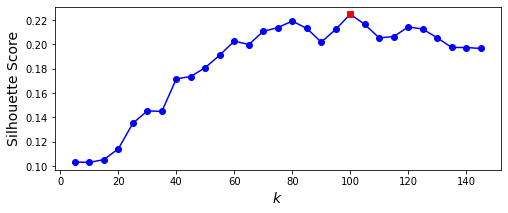

In [6]:
from sklearn.metrics import silhouette_score

k_range = list(range(5, 150, 5))
silhouette_scores = []
inertias = []
models = []

for k in k_range:
    kmeans = KMeans(n_clusters=k).fit(X_train_pca)
    silhouette_scores.append(silhouette_score(X_train_pca, kmeans.labels_))
    inertias.append(kmeans.inertia_)
    models.append(kmeans)
    
best_model_idx = np.argmax(silhouette_scores)
best_k = k_range[best_model_idx]
best_score = silhouette_scores[best_model_idx]
best_inertia = inertias[best_model_idx]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.plot(best_k, best_score, 'rs')
plt.show()

In [7]:
best_k

100

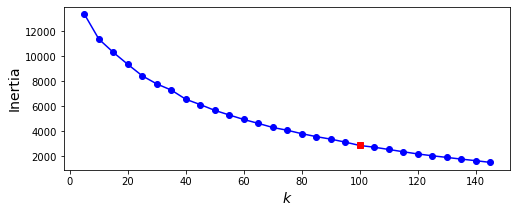

In [8]:
plt.figure(figsize=(8, 3))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, 'rs')
plt.show()

There is no obvious elbow in this diagram, so we will go with the best k that the silhouette plot gives us:

In [9]:
best_model = models[best_model_idx]

Cluster 55


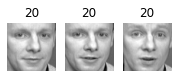

Cluster 46


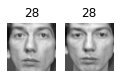

Cluster 54


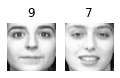

Cluster 3


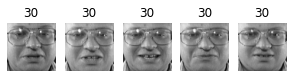

Cluster 51


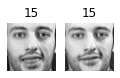

Cluster 63


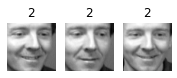

Cluster 60


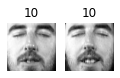

Cluster 26


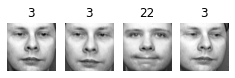

Cluster 99


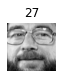

Cluster 25


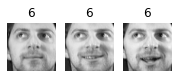

In [10]:
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(face.reshape(64, 64), cmap='gray')
        plt.axis('off')
        plt.title(label)
    plt.show()

# Select some clusters to be shown
some_clusters = np.random.choice(np.unique(best_model.labels_), 10)

for cluster_id in some_clusters:
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_ == cluster_id
    faces = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

## 11.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier().fit(X_train_pca, y_train)
rf_clf.score(X_val_pca, y_val)

ERROR! Session/line number was not unique in database. History logging moved to new session 889


0.890625

In [12]:
from sklearn.pipeline import Pipeline

X_train_reduced = best_model.transform(X_train_pca)
X_val_reduced = best_model.transform(X_val_pca)
X_test_reduced = best_model.transform(X_test_pca)

for k in k_range:
    pipeline = Pipeline([
        ('kmeans', KMeans(n_clusters=k, random_state=42)),
        ('random_forest', RandomForestClassifier(random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(k, pipeline.score(X_val_pca, y_val))

5 0.4375
10 0.53125
15 0.609375
20 0.59375
25 0.671875
30 0.640625
35 0.6875
40 0.6875
45 0.71875
50 0.734375
55 0.71875
60 0.796875
65 0.71875
70 0.703125
75 0.71875
80 0.765625
85 0.703125
90 0.71875
95 0.75
100 0.703125
105 0.765625
110 0.75
115 0.75
120 0.75
125 0.71875
130 0.765625
135 0.765625
140 0.75
145 0.75


Even with grid search we couldn't find a single model that is able to reach over 80% accuracy on the validation set. Let's try appending this reduced set to the original features and see how it compares:

In [13]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_val_extended = np.c_[X_val_pca, X_val_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

rf_clf = RandomForestClassifier().fit(X_train_extended, y_train)
rf_clf.score(X_val_extended, y_val)

0.796875

A bit better, but these original features didn't help in this case. 

## 12.

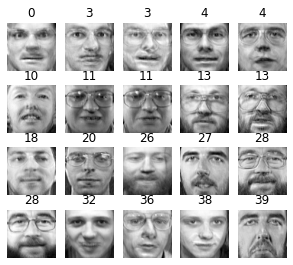

In [14]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=40).fit(X_train_pca)
gen_samples_reduced, gen_labels = gmm.sample(20)
gen_samples = pca.inverse_transform(gen_samples_reduced)
plot_faces(gen_samples, gen_labels)

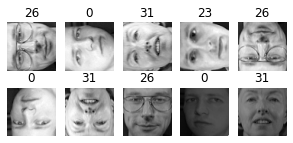

In [15]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [16]:
X_bad_faces_pca = pca.transform(X_bad_faces)
gmm.score_samples(X_bad_faces_pca)

array([-3.28476904e+07, -7.41003174e+07, -2.73239224e+07, -3.42367174e+07,
       -4.48970817e+07, -4.10621639e+07, -4.01017361e+07, -1.04046517e+08,
       -1.14207389e+08, -9.83111353e+07])

All the bad faces were considered extremely unlikely the the Gaussian Mixture model. This is much more clear if we compare this to the scores of some training instances:

In [17]:
gmm.score_samples(X_train_pca[:10])

array([1057.26116425, 1065.13961445, 1042.15824169, 1043.23885126,
       1040.80352667, 1064.93057517, 1073.93641129, 1066.35893683,
       1064.62180406, 1057.26689102])

## 13.

In [18]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [19]:
reconstruction_errors(pca, X_train).mean()

0.00018421722

In [20]:
reconstruction_errors(pca, X_bad_faces).mean()

0.0059456797

We can see that the reconstruction error for the bad faces is much higher! As expected, the reconstruction result is pretty bad as well:

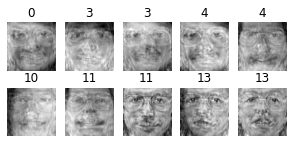

In [21]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, gen_labels)